In [9]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf


In [10]:

# Define data directories
train_data_dir = 'Archive/train_v'
validation_data_dir = 'Archive/validation'
test_data_dir = 'Archive/test_v'

In [11]:
# Image size and batch size
img_width, img_height = 150, 150
batch_size = 32

In [12]:
# Data augmentation for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data augmentation for the validation and test datasets
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [13]:
# Load and preprocess data for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data for confusion matrix
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [14]:
# Build a CNN model
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# convolution and MaxPooling layers
model = keras.models.Sequential([
keras.layers.Conv2D(filters=64, kernel_size=7, strides=(1,1), activation="relu", padding="same", input_shape=[150, 150, 3]), # img_width, img_height, 3
keras.layers.MaxPooling2D(4,4),

keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same"),
keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
keras.layers.MaxPooling2D(4,4),

keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
keras.layers.MaxPooling2D(4,4),

# fully connected layers
keras.layers.Flatten(),
keras.layers.Dense(128, activation="relu"),
keras.layers.Dropout(0.5),
keras.layers.Dense(64, activation="relu"),
keras.layers.Dropout(0.5),

# number of classes(vegetables)
keras.layers.Dense(15, activation="softmax")
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      9472      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 9, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 256)        

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])

In [16]:
# Train the model using the training data and validate it using the validation data
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Assess the model's performance using accuracy as the metric
score = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy: {:.2f}%".format(score[1] * 100))



Epoch 1/30
469/469 [==============================] - 369s 787ms/step - loss: 2.4901 - accuracy: 0.1377 - val_loss: 2.0878 - val_accuracy: 0.3563
Epoch 2/30
469/469 [==============================] - 341s 728ms/step - loss: 1.9868 - accuracy: 0.3182 - val_loss: 1.4793 - val_accuracy: 0.5017
Epoch 3/30
469/469 [==============================] - 315s 672ms/step - loss: 1.6054 - accuracy: 0.4424 - val_loss: 1.1016 - val_accuracy: 0.6493
Epoch 4/30
469/469 [==============================] - 321s 683ms/step - loss: 1.2882 - accuracy: 0.5541 - val_loss: 0.9869 - val_accuracy: 0.6883
Epoch 5/30
469/469 [==============================] - 321s 683ms/step - loss: 1.0706 - accuracy: 0.6354 - val_loss: 0.6215 - val_accuracy: 0.7913
Epoch 6/30
469/469 [==============================] - 320s 682ms/step - loss: 0.9021 - accuracy: 0.6975 - val_loss: 0.5711 - val_accuracy: 0.8053
Epoch 7/30
469/469 [==============================] - 322s 686ms/step - loss: 0.7445 - accuracy: 0.7554 - val_loss: 0.4395 -

3000/3000 [==============================] - 30s 10ms/step


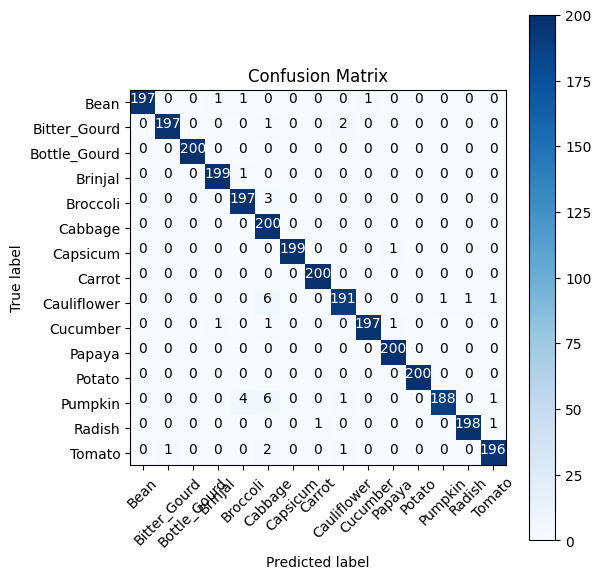

In [17]:
# plot a confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define class names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)
plt.show()

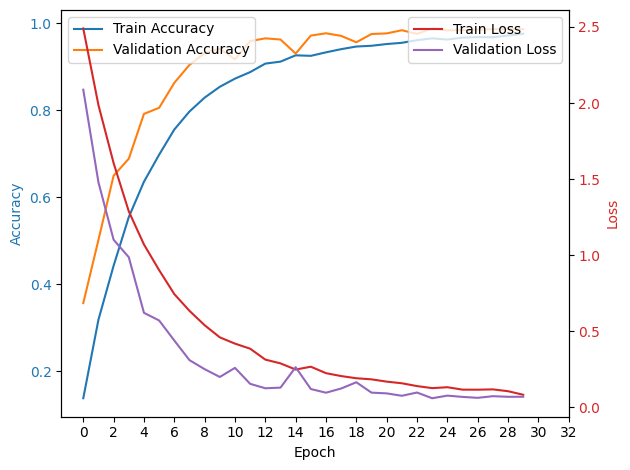

In [18]:
# Plot training & validation accuracy values
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], color='tab:orange', label='Validation Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for the loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax2.plot(history.history['val_loss'], color='tab:purple', label='Validation Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Set the x-axis ticks to go up to 32 epochs
ax1.set_xticks(range(0, 33, 2))
ax2.set_xticks(range(0, 33, 2))

fig.tight_layout()
plt.show()


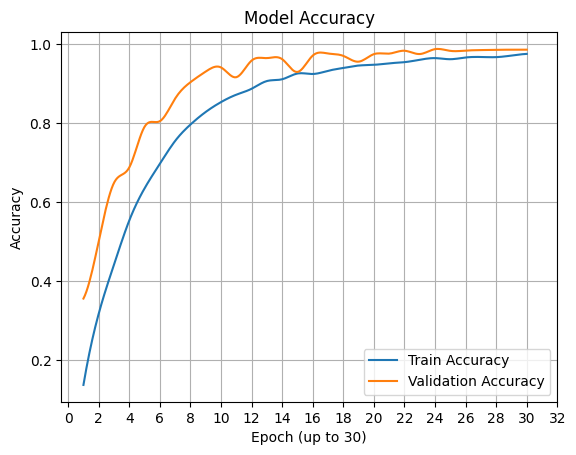

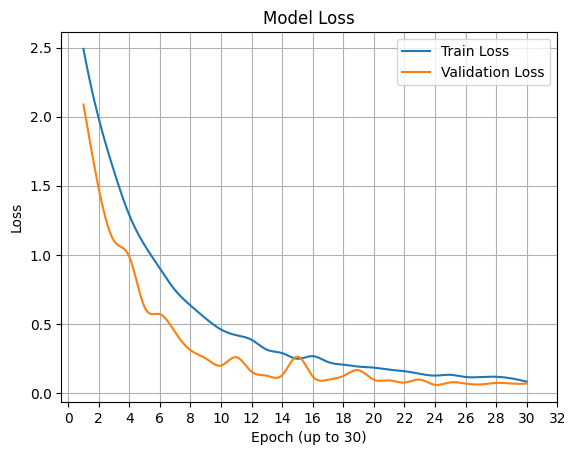

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Create a higher-resolution array for the x-axis
epochs_original = np.arange(1, 31)
epochs_smooth = np.linspace(epochs_original.min(), epochs_original.max(), 300)

# Smooth the training & validation accuracy values
accuracy_smooth = make_interp_spline(epochs_original, history.history['accuracy'])(epochs_smooth)
val_accuracy_smooth = make_interp_spline(epochs_original, history.history['val_accuracy'])(epochs_smooth)

# Plot smoothed training & validation accuracy values
plt.plot(epochs_smooth, accuracy_smooth, label='Train Accuracy')
plt.plot(epochs_smooth, val_accuracy_smooth, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch (up to 30)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 33, 2))
plt.show()

# Smooth the training & validation loss values
loss_smooth = make_interp_spline(epochs_original, history.history['loss'])(epochs_smooth)
val_loss_smooth = make_interp_spline(epochs_original, history.history['val_loss'])(epochs_smooth)

# Plot smoothed training & validation loss values
plt.plot(epochs_smooth, loss_smooth, label='Train Loss')
plt.plot(epochs_smooth, val_loss_smooth, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch (up to 30)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 33, 2))
plt.show()


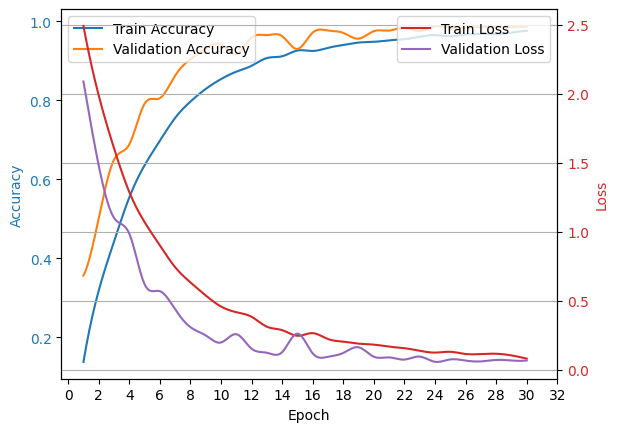

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Create a higher-resolution array for the x-axis
epochs_original = np.arange(1, 31)
epochs_smooth = np.linspace(epochs_original.min(), epochs_original.max(), 300)

# Smooth the training & validation accuracy values
accuracy_smooth = make_interp_spline(epochs_original, history.history['accuracy'])(epochs_smooth)
val_accuracy_smooth = make_interp_spline(epochs_original, history.history['val_accuracy'])(epochs_smooth)

# Smooth the training & validation loss values
loss_smooth = make_interp_spline(epochs_original, history.history['loss'])(epochs_smooth)
val_loss_smooth = make_interp_spline(epochs_original, history.history['val_loss'])(epochs_smooth)

# Plot both accuracy and loss on the same plot
fig, ax1 = plt.subplots()

# Plot accuracy
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs_smooth, accuracy_smooth, color='tab:blue', label='Train Accuracy', linestyle='-')
ax1.plot(epochs_smooth, val_accuracy_smooth, color='tab:orange', label='Validation Accuracy', linestyle='-')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for the loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(epochs_smooth, loss_smooth, color='tab:red', label='Train Loss', linestyle='-')
ax2.plot(epochs_smooth, val_loss_smooth, color='tab:purple', label='Validation Loss', linestyle='-')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')



plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 33, 2))
plt.show()
